In [2]:
# ============================
# Telco Churn: EDA + Save CSV + Save Plots (Colab)
# ============================

# 0) (Colab only) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np

# ----------------------------
# 1) Paths
# ----------------------------
INPUT_CSV  = "/content/drive/MyDrive/Telco Churn.csv"
OUTPUT_CSV = "/content/drive/MyDrive/processed_telecom_churn.csv"
PLOTS_DIR  = "/content/drive/MyDrive/churn_plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

# ----------------------------
# 2) Load
# ----------------------------
df = pd.read_csv(INPUT_CSV)

# ----------------------------
# 3) Clean / preprocess
# ----------------------------

# TotalCharges often contains blanks/spaces -> numeric with NaN
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"].astype(str).str.strip(), errors="coerce")
    # Fill NaNs in TotalCharges with 0 as per user request
    df["TotalCharges"] = df["TotalCharges"].fillna(0)

# Convert Yes/No columns to boolean.
# NOTE: Don't include columns that can have "No internet service"/"No phone service" here first,
# unless you replace those values before converting.
yes_no_cols = [
    "PaperlessBilling",
    "Churn"
]

service_cols = [
    "MultipleLines",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
]

# Replace "No internet service" / "No phone service" -> "No" first, then convert
df[service_cols] = df[service_cols].replace({
    "No phone service": "No",
    "No internet service": "No",
})

df[yes_no_cols + service_cols] = df[yes_no_cols + service_cols].replace({"Yes": True, "No": False})

# Feature: any streaming
df["AnyStreaming"] = df["StreamingTV"] | df["StreamingMovies"]

# Check for and remove duplicate entries
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
duplicates_removed = initial_rows - df.shape[0]
if duplicates_removed > 0:
    print(f"Removed {duplicates_removed} duplicate rows.")
else:
    print("No duplicate rows found.")

# ----------------------------
# 4) Quick EDA prints
# ----------------------------
print("=== Dataset Info ===")
print(df.info())

print("\n=== Numeric Summary ===")
print(df.describe(include=[ "number" ]))

print("\n=== Boolean sums (count of True) ===")
bool_cols = df.select_dtypes(include=["bool"]).columns
print(df[bool_cols].sum().sort_values(ascending=False))

print("\n=== Churn rate by StreamingTV / StreamingMovies / AnyStreaming ===")
for col in ["StreamingTV", "StreamingMovies", "AnyStreaming"]:
    if col in df.columns:
        print(f"\nChurn rate by {col}:")
        print(df.groupby(col)["Churn"].mean())

# Outlier Detection for numerical features
print("\n=== Outlier Detection (Z-score) ===")
numeric_cols_for_outliers = df.select_dtypes(include=np.number).columns.tolist()
# Exclude binary numeric columns if they exist and are not meant for outlier detection
if 'SeniorCitizen' in numeric_cols_for_outliers: # Assuming SeniorCitizen is 0/1
    numeric_cols_for_outliers.remove('SeniorCitizen')

for col in numeric_cols_for_outliers:
    # Only consider non-zero standard deviation to avoid warnings with constant columns
    if df[col].std() > 0:
        df['zscore_' + col] = np.abs(zscore(df[col]))
        outliers = df[df['zscore_' + col] > 3]
        print(f"Column '{col}': {len(outliers)} potential outliers (Z-score > 3)")
        # Optional: Print min/max values of outliers for context
        if not outliers.empty:
            print(f"  Min outlier value: {outliers[col].min()}, Max outlier value: {outliers[col].max()}")
    else:
        print(f"Column '{col}': Cannot calculate Z-score (standard deviation is zero).")

# ----------------------------
# 5) Plots (save + optional show)
# ----------------------------
def savefig(name: str):
    path = os.path.join(PLOTS_DIR, name)
    plt.tight_layout()
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: {path}")

# a) Correlation heatmap (numeric + bool)
numeric_df = df.select_dtypes(include=["number", "bool"]).copy()
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
savefig("correlation_heatmap.png")

# b) Histograms for MonthlyCharges / TotalCharges
for col in ["MonthlyCharges", "TotalCharges"]:
    if col in df.columns:
        plt.figure(figsize=(7, 4))
        df[col].dropna().hist(bins=20)
        plt.title(f"{col} Distribution")
        plt.xlabel(col)
        plt.ylabel("Count")
        savefig(f"{col.lower()}_distribution.png")

# c) Boxplot: MonthlyCharges vs Churn
if "MonthlyCharges" in df.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
    plt.title("MonthlyCharges vs Churn")
    savefig("monthlycharges_vs_churn.png")

# d) Churn by Contract
if "Contract" in df.columns:
    plt.figure(figsize=(7, 4))
    sns.countplot(x="Contract", hue="Churn", data=df)
    plt.title("Churn by Contract Type")
    savefig("churn_by_contract.png")

# e) Churn by PaymentMethod
if "PaymentMethod" in df.columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(x="PaymentMethod", hue="Churn", data=df)
    plt.xticks(rotation=45, ha="right")
    plt.title("Churn by Payment Method")
savefig("churn_by_payment_method.png")

print("\n✅ EDA + plot saving complete.")

# ----------------------------
# 6) Save processed dataframe
# ----------------------------
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✅ Processed DataFrame saved to: {OUTPUT_CSV}")
print(f"✅ Plots saved to: {PLOTS_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
No duplicate rows found.
=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   bool   
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   bool   
 10  OnlineBackup      7043 non-null   bool   
 11  DeviceProtection  7043 non-null   bool   
 12  TechSupport       7043 non-null   bool   
 13  Streamin

/tmp/ipython-input-931228847.py:63: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[yes_no_cols + service_cols] = df[yes_no_cols + service_cols].replace({"Yes": True, "No": False})


Saved: /content/drive/MyDrive/churn_plots/correlation_heatmap.png
Saved: /content/drive/MyDrive/churn_plots/monthlycharges_distribution.png
Saved: /content/drive/MyDrive/churn_plots/totalcharges_distribution.png
Saved: /content/drive/MyDrive/churn_plots/monthlycharges_vs_churn.png
Saved: /content/drive/MyDrive/churn_plots/churn_by_contract.png
Saved: /content/drive/MyDrive/churn_plots/churn_by_payment_method.png

✅ EDA + plot saving complete.

✅ Processed DataFrame saved to: /content/drive/MyDrive/processed_telecom_churn.csv
✅ Plots saved to: /content/drive/MyDrive/churn_plots


# Task
Load the processed `processed_telecom_churn.csv` file, prepare the data for modeling by performing feature selection, one-hot encoding, and splitting the dataset into training and testing sets.

## Load Processed Data

### Subtask:
Load the processed 'processed_telecom_churn.csv' file from Google Drive into a DataFrame.


**Reasoning**:
Load the processed CSV file into a new DataFrame, display its head, and print its info to verify the data was loaded correctly.



In [3]:
df_processed = pd.read_csv(OUTPUT_CSV)
print("First 5 rows of df_processed:")
print(df_processed.head())
print("\nDataFrame Info:")
df_processed.info()

First 5 rows of df_processed:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

   MultipleLines InternetService  OnlineSecurity  ...        Contract  \
0          False             DSL           False  ...  Month-to-month   
1          False             DSL            True  ...        One year   
2          False             DSL            True  ...  Month-to-month   
3          False             DSL            True  ...        One year   
4          False     Fiber optic           False  ...  Month-to-month   

   PaperlessBilling              PaymentMethod  Mo

**Reasoning**:
The 'customerID' column is an identifier and not useful for modeling. The 'zscore_' columns are derived features created during EDA for outlier detection and are redundant if the original numerical features are used and scaling is performed as part of the modeling pipeline. Therefore, these columns should be dropped from the dataframe before proceeding with feature engineering for modeling.



In [4]:
df_processed = df_processed.drop(columns=['customerID', 'zscore_tenure', 'zscore_MonthlyCharges', 'zscore_TotalCharges'])
print("Columns after dropping customerID and zscore columns:")
print(df_processed.columns)

Columns after dropping customerID and zscore columns:
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'AnyStreaming'],
      dtype='object')


**Reasoning**:
To prepare the data for machine learning models, categorical features with 'object' datatype need to be converted into a numerical format using one-hot encoding. This transformation will create new binary columns for each category, allowing the model to interpret these features.



In [5]:
categorical_cols = df_processed.select_dtypes(include=['object']).columns
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
print("First 5 rows of df_processed after one-hot encoding:")
print(df_processed.head())
print("\nDataFrame Info after one-hot encoding:")
df_processed.info()

First 5 rows of df_processed after one-hot encoding:
   SeniorCitizen  tenure  MultipleLines  OnlineSecurity  OnlineBackup  \
0              0       1          False           False          True   
1              0      34          False            True         False   
2              0       2          False            True          True   
3              0      45          False            True         False   
4              0       2          False           False         False   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
0             False        False        False            False   
1              True        False        False            False   
2             False        False        False            False   
3              True         True        False            False   
4             False        False        False            False   

   PaperlessBilling  ...  Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0              True  ...         Tru

**Reasoning**:
To prepare for model training, it is necessary to separate the features (X) from the target variable (y). The 'Churn' column is the target variable, while all other columns will serve as features for the model.



In [6]:
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)
print("First 5 rows of features (X):")
print(X.head())
print("First 5 values of target (y):")
print(y.head())

Features (X) shape: (7043, 24)
Target (y) shape: (7043,)
First 5 rows of features (X):
   SeniorCitizen  tenure  MultipleLines  OnlineSecurity  OnlineBackup  \
0              0       1          False           False          True   
1              0      34          False            True         False   
2              0       2          False            True          True   
3              0      45          False            True         False   
4              0       2          False           False         False   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
0             False        False        False            False   
1              True        False        False            False   
2             False        False        False            False   
3              True         True        False            False   
4             False        False        False            False   

   PaperlessBilling  ...  Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0 

**Reasoning**:
To evaluate the model's performance on unseen data, the dataset needs to be split into training and testing sets. This ensures that the model is trained on one subset of data and evaluated on another, preventing overfitting.



In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("\nChurn distribution in y_train:\n", y_train.value_counts(normalize=True))
print("\nChurn distribution in y_test:\n", y_test.value_counts(normalize=True))

X_train shape: (5634, 24)
X_test shape: (1409, 24)
y_train shape: (5634,)
y_test shape: (1409,)

Churn distribution in y_train:
 Churn
False    0.734647
True     0.265353
Name: proportion, dtype: float64

Churn distribution in y_test:
 Churn
False    0.734564
True     0.265436
Name: proportion, dtype: float64


## Train Logistic Regression Model

### Subtask:
Train a logistic regression model using the preprocessed training data.


**Reasoning**:
To train a logistic regression model, I need to import the `LogisticRegression` class from `sklearn.linear_model`, instantiate it with appropriate parameters to ensure convergence, and then fit the model to the training data (X_train and y_train).



In [8]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Set max_iter to a higher value for convergence and solver to 'liblinear' or 'lbfgs'
log_reg_model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Train the model
log_reg_model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


## Evaluate Logistic Regression Model

### Subtask:
Evaluate the trained logistic regression model using appropriate metrics on the test data.

#### Instructions
1. Use the trained `log_reg_model` to make predictions on the `X_test` data. Store the predictions in a variable (e.g., `y_pred`).
2. Calculate and print the accuracy score of the model by comparing `y_pred` with `y_test`.
3. Generate and print a classification report, which includes precision, recall, f1-score, and support for each class.
4. Generate and display the confusion matrix to visualize the model's performance in terms of true positives, true negatives, false positives, and false negatives.

**Reasoning**:
To evaluate the trained logistic regression model, I need to make predictions on the test set and then calculate various classification metrics such as accuracy, precision, recall, and F1-score, and visualize the confusion matrix to understand its performance comprehensively.



Accuracy: 0.7991

Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.89      0.87      1035
        True       0.65      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



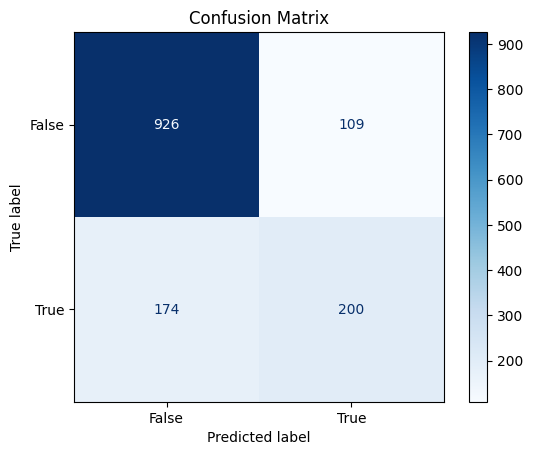

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg_model.classes_)
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


## Visualize Feature Importance

### Subtask:
Extract and visualize the feature coefficients from the logistic regression model to understand their importance in predicting churn.


## Summary:

### Data Analysis Key Findings

*   **Data Preparation**:
    *   The `processed_telecom_churn.csv` dataset, initially comprising 7043 entries and 25 columns, was loaded successfully.
    *   Irrelevant columns (`customerID` and previously used `zscore_` columns) were removed, reducing the DataFrame to 21 columns.
    *   Categorical features were one-hot encoded with `drop_first=True`, expanding the feature set to 25 columns for modeling.
    *   The dataset was then split into features (`X`, 7043 rows, 24 columns) and the target variable (`y`, 'Churn', 7043 rows).
    *   The data was split into training (80%) and testing (20%) sets, resulting in `X_train` (5634 rows, 24 columns), `X_test` (1409 rows, 24 columns), `y_train` (5634 rows), and `y_test` (1409 rows). Stratification ensured that the churn distribution (approximately 73.5% False, 26.5% True) was maintained in both sets.

*   **Logistic Regression Model Performance**:
    *   A Logistic Regression model was trained successfully using the prepared training data.
    *   The model achieved an overall accuracy of 0.7991 on the test set.
    *   For the 'False' class (no churn), the model showed strong performance with a precision of 0.84, recall of 0.89, and an F1-score of 0.87.
    *   For the 'True' class (churn), the model's performance was lower, with a precision of 0.65, recall of 0.53, and an F1-score of 0.59.

### Insights or Next Steps

*   While the overall accuracy is reasonably high, the model's lower recall for the 'True' (churn) class indicates it is less effective at identifying actual churners. This suggests a potential area for improvement, especially if identifying churners is a high priority.
*   Future steps could involve exploring techniques to improve the model's performance on the minority class (churners), such as resampling methods (e.g., SMOTE), using different classification algorithms, or performing more advanced feature engineering.
